In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install rdkit xgboost lightgbm catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 448.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.2 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_df = pd.read_parquet('/content/drive/MyDrive/DS5500/train_df_long_dt.parquet')

In [5]:
train_df.head()

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_names,binds,ecfp
0,O=C(N[C@@H](Cc1ccc(F)cc1)C(=O)O)OCC1c2ccccc2-c...,COc1cccc(-c2cc(N)on2)c1,Cl.Cl.NCCC(=O)Nc1ccncc1,COc1cccc(-c2cc(Nc3nc(NCCC(=O)Nc4ccncc4)nc(N[C@...,BRD4,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,COc1cc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)c...,NCc1cccc(C(F)(F)F)n1,Cl.Cl.NCc1nccc2[nH]ccc12,COc1cc(Nc2nc(NCc3cccc(C(F)(F)F)n3)nc(NCc3nccc4...,BRD4,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(Nc1ccc(C(=O)O)cc1O)OCC1c2ccccc2-c2ccccc21,C=C(C)C(=O)NCCN.Cl,CSc1nnc(CN)s1,C=C(C)C(=O)NCCNc1nc(NCc2nnc(SC)s2)nc(Nc2ccc(C(...,BRD4,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,O=C(O)[C@H]1Cc2ccccc2CN1C(=O)OCC1c2ccccc2-c2cc...,Nc1cccnc1[N+](=O)[O-],CC1CC(CN)C(C)O1,CC1CC(CNc2nc(Nc3cccnc3[N+](=O)[O-])nc(N3Cc4ccc...,BRD4,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C(N[C@@H](Cc1c(F)c(F)c(F)c(F)c1F)C(=O)O)OCC1...,CN1C(=O)Cc2cc(CN)ccc21.Cl,Cl.Cl.NCc1ccc2scnc2c1,CN1C(=O)Cc2cc(CNc3nc(NCc4ccc5scnc5c4)nc(N[C@@H...,BRD4,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np
#from tqdm.notebook import tqdm  # For progress bar

# OneHotEncode the 'protein_name' column
onehot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse=False for dense matrix
onehot_encoder

OneHotEncoder(sparse_output=False)

In [7]:
protein_onehot_train = onehot_encoder.fit_transform(train_df['protein_names'].values.reshape(-1, 1))

In [11]:
import numpy as np

# Convert lists to NumPy arrays
ecfp_array = np.array(train_df['ecfp'].tolist(), dtype=np.float32)
protein_array = np.array(protein_onehot_train.tolist(), dtype=np.float32)
binds_array = np.array(train_df['binds'].tolist(), dtype=np.int8)

# Combine arrays
X = np.hstack((ecfp_array, protein_array))
y = binds_array

print("X:", X)
print("y:", y)

X: [[0. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]
y: [0 0 0 ... 1 1 0]


In [16]:
import os
import pickle

save_directory = '/content/drive/MyDrive/DS5500/'
os.makedirs(save_directory, exist_ok=True)

# Save files
with open(os.path.join(save_directory, 'X.pkl'), 'wb') as f:
    pickle.dump(X, f)

with open(os.path.join(save_directory, 'y.pkl'), 'wb') as f:
    pickle.dump(y, f)

print(f"Files saved to: {save_directory}")


Files saved to: /content/drive/MyDrive/DS5500/


In [5]:
#load pickle files
import pickle
import os

# Specify the directory and file name
save_directory = '/content/drive/MyDrive/DS5500/'  # Adjust to your specific location
file_name_X = 'X.pkl'  # Replace with the actual file name if different
file_name_y = 'y.pkl'  # Replace with the actual file name if different

# Load the pickle files
with open(os.path.join(save_directory, file_name_X), 'rb') as f:
    X = pickle.load(f)

with open(os.path.join(save_directory, file_name_y), 'rb') as f:
    y = pickle.load(f)

# Print confirmation and details
print(f"Loaded X with shape: {len(X)} rows")
print(f"Loaded y with shape: {len(y)} rows")


Loaded X with shape: 10191006 rows
Loaded y with shape: 10191006 rows


In [6]:
print(len(X))
print(len(y))

10191006
10191006


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
len(X_train)
len(y_train)

8152804

In [9]:
# Convert y_train to a NumPy array for calculations
y_train = np.array(y_train)

# Calculate class imbalance ratio
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Output the scale_pos_weight
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

Scale Pos Weight: 7.55


## **Baseline Model**

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, average_precision_score
from sklearn.model_selection import cross_val_score
import joblib

# Define selected models
logistic_regression = LogisticRegression(class_weight='balanced', max_iter=200)

decision_tree = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=105)

random_forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=30,
    class_weight="balanced",
    random_state=105,
    n_jobs=-1
)

xgboost = XGBClassifier(
    n_estimators=100,
    max_depth=50,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.1,
    objective='binary:logistic',  # Correct objective for binary classification
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    tree_method='hist'  # Fast histogram-based training
)


lgbm = LGBMClassifier(
    n_estimators=50,
    max_depth=50,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.1
)

catboost = CatBoostClassifier(
    iterations=50,
    depth=6,
    learning_rate=0.1,
    verbose=0,
    scale_pos_weight=scale_pos_weight
)

# Define directory to save models
save_directory = "/content/drive/MyDrive/DS5500/saved_models/"
os.makedirs(save_directory, exist_ok=True)

# Train and save the models
def train_save_evaluate_model(name, model, X_train, y_train, X_val, y_val, save_directory):
    try:
        print(f"\nTraining {name}...")
        # Train the model
        model.fit(X_train, y_train)

        # Save the model
        model_path = os.path.join(save_directory, f"{name.replace(' ', '_')}.pkl")
        joblib.dump(model, model_path)
        print(f"Model saved to {model_path}")

        # Predictions
        pred_model = model.predict(X_val)
        pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Metrics
        accuracy = accuracy_score(y_val, pred_model)
        weighted_map = (
            average_precision_score(y_val, pred_proba, average='weighted') if pred_proba is not None else None
        )

        # Classification report
        report = classification_report(y_val, pred_model)

        # Display results
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.2f}")
        if weighted_map is not None:
            print(f"Weighted mAP: {weighted_map:.2f}")
        print(report)

    except Exception as e:
        print(f"Model: {name} encountered an error: {str(e)}")


In [25]:
# Train, save, and evaluate models
train_save_evaluate_model("Logistic Regression", logistic_regression, X_train, y_train, X_val, y_val, save_directory)



Training Logistic Regression...
Model saved to /content/drive/MyDrive/DS5500/saved_models/Logistic_Regression.pkl
Model: Logistic Regression
Accuracy: 0.75
Weighted mAP: 0.35
              precision    recall  f1-score   support

           0       0.97      0.75      0.84   1799365
           1       0.30      0.81      0.44    238837

    accuracy                           0.75   2038202
   macro avg       0.63      0.78      0.64   2038202
weighted avg       0.89      0.75      0.80   2038202



In [38]:
train_save_evaluate_model("XGBoost", xgboost, X_train, y_train, X_val, y_val, save_directory)


Training XGBoost...
Model saved to /content/drive/MyDrive/DS5500/saved_models/XGBoost.pkl
Model: XGBoost
Accuracy: 0.96
Weighted mAP: 0.90
              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1799365
           1       0.79      0.83      0.81    238837

    accuracy                           0.96   2038202
   macro avg       0.89      0.90      0.89   2038202
weighted avg       0.96      0.96      0.96   2038202



In [32]:
train_save_evaluate_model("LGBM", lgbm, X_train, y_train, X_val, y_val, save_directory)


Training LGBM...
[LightGBM] [Info] Number of positive: 953391, number of negative: 7199413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.606618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8152804, number of used features: 1020
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116940 -> initscore=-2.021730
[LightGBM] [Info] Start training from score -2.021730
Model saved to /content/drive/MyDrive/DS5500/LGBM.pkl
Model: LGBM
Accuracy: 0.91
Weighted mAP: 0.79
              precision    recall  f1-score   support

           0       0.98      0.91      0.94   1799365
           1       0.56      0.84      0.68    238837

    accuracy                           0.91   2038202
   macro avg       0.77      0.88      0.81   2038202
weighted avg       0.93      0.91      0.91  

In [33]:
train_save_evaluate_model("CatBoost", catboost, X_train, y_train, X_val, y_val, save_directory)


Training CatBoost...
Model saved to /content/drive/MyDrive/DS5500/CatBoost.pkl
Model: CatBoost
Accuracy: 0.89
Weighted mAP: 0.74
              precision    recall  f1-score   support

           0       0.97      0.90      0.93   1799365
           1       0.51      0.79      0.62    238837

    accuracy                           0.89   2038202
   macro avg       0.74      0.85      0.78   2038202
weighted avg       0.92      0.89      0.90   2038202



In [34]:
train_save_evaluate_model("Decision Tree", decision_tree, X_train, y_train, X_val, y_val, save_directory)


Training Decision Tree...
Model saved to /content/drive/MyDrive/DS5500/Decision_Tree.pkl
Model: Decision Tree
Accuracy: 0.80
Weighted mAP: 0.58
              precision    recall  f1-score   support

           0       0.96      0.81      0.88   1799365
           1       0.34      0.72      0.46    238837

    accuracy                           0.80   2038202
   macro avg       0.65      0.77      0.67   2038202
weighted avg       0.88      0.80      0.83   2038202



In [11]:
train_save_evaluate_model("Random Forest", random_forest, X_train, y_train, X_val, y_val, save_directory)


Training Random Forest...
Model saved to /content/drive/MyDrive/DS5500/saved_models/Random_Forest.pkl
Model: Random Forest
Accuracy: 0.86
Weighted mAP: 0.65
              precision    recall  f1-score   support

           0       0.95      0.89      0.92   1799365
           1       0.44      0.65      0.53    238837

    accuracy                           0.86   2038202
   macro avg       0.70      0.77      0.72   2038202
weighted avg       0.89      0.86      0.87   2038202



## **Baseline Model inference**

Loaded Logistic Regression model from /content/drive/MyDrive/DS5500/saved_models/Logistic_Regression.pkl


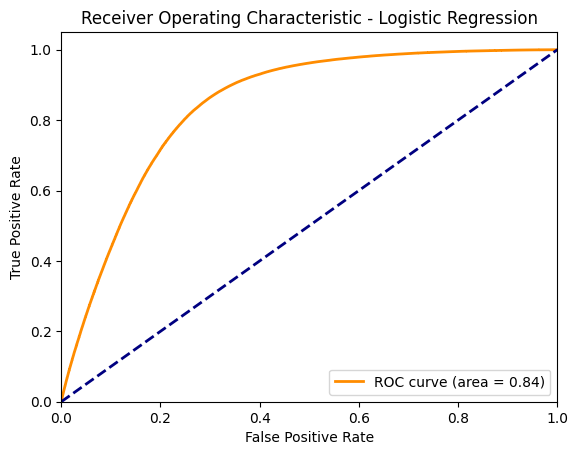

Accuracy: 0.75


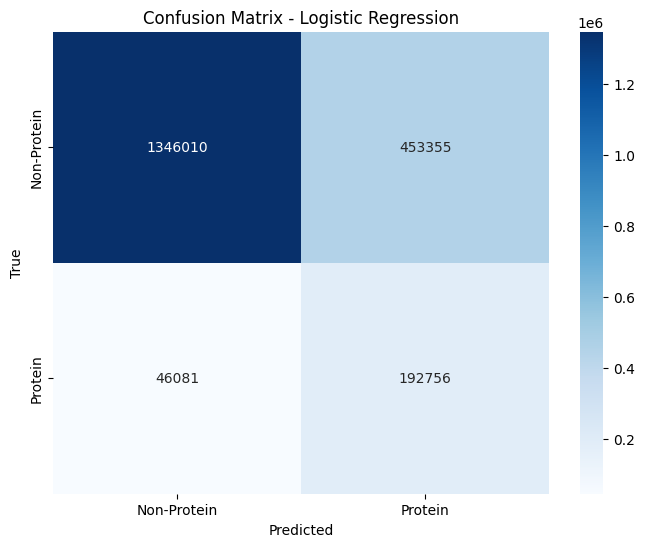

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.84   1799365
           1       0.30      0.81      0.44    238837

    accuracy                           0.75   2038202
   macro avg       0.63      0.78      0.64   2038202
weighted avg       0.89      0.75      0.80   2038202



In [36]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix, classification_report
)

# Define file path
model_path = "/content/drive/MyDrive/DS5500/saved_models/Logistic_Regression.pkl"

# Load the saved Logistic Regression model
try:
    model = joblib.load(model_path)
    print(f"Loaded Logistic Regression model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred = model.predict(X_val)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


Loaded XGBoost model from /content/drive/MyDrive/DS5500/saved_models/XGBoost.pkl


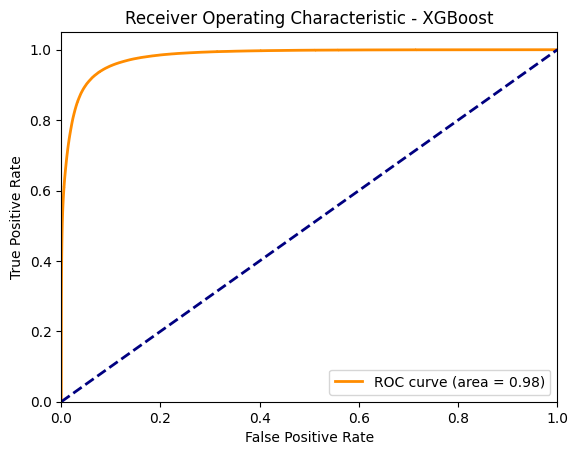

Accuracy: 0.96


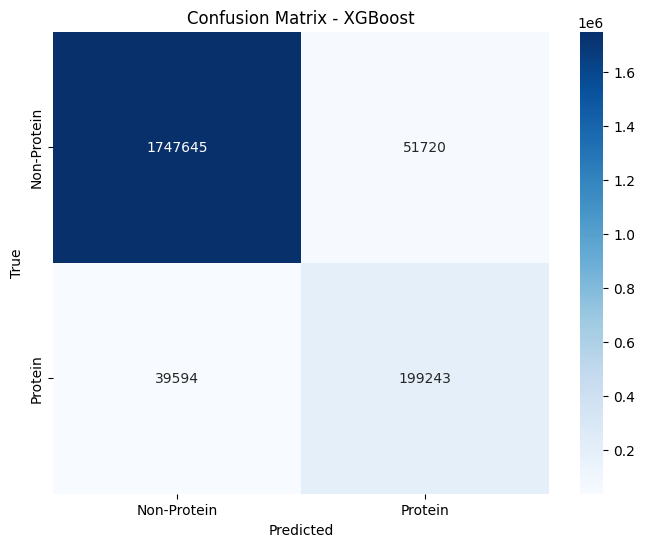

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1799365
           1       0.79      0.83      0.81    238837

    accuracy                           0.96   2038202
   macro avg       0.89      0.90      0.89   2038202
weighted avg       0.96      0.96      0.96   2038202



In [39]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix, classification_report
)

# Define file path
model_path = "/content/drive/MyDrive/DS5500/saved_models/XGBoost.pkl"

# Load the saved XGBoost model
try:
    model = joblib.load(model_path)
    print(f"Loaded XGBoost model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred = model.predict(X_val)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


Loaded LGBM model from /content/drive/MyDrive/DS5500/LGBM.pkl


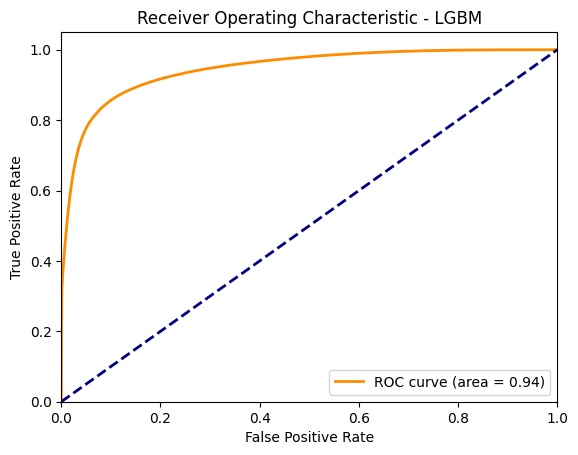

Accuracy: 0.91


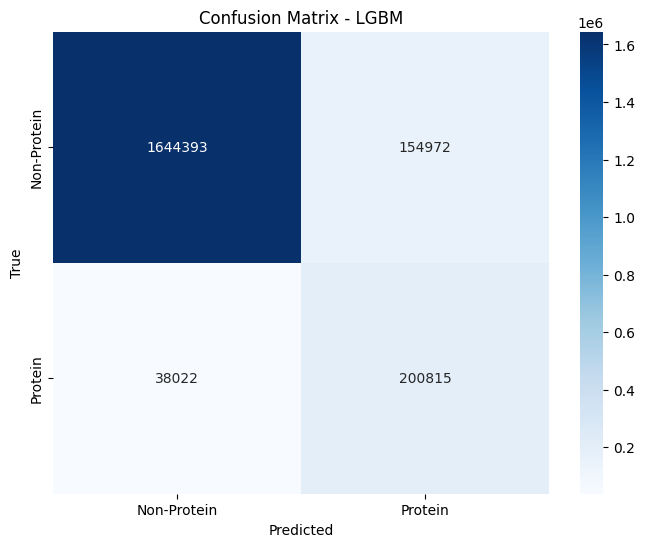

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94   1799365
           1       0.56      0.84      0.68    238837

    accuracy                           0.91   2038202
   macro avg       0.77      0.88      0.81   2038202
weighted avg       0.93      0.91      0.91   2038202



In [40]:

# Define file path
model_path = "/content/drive/MyDrive/DS5500/LGBM.pkl"

# Load the saved LGBM model
try:
    model = joblib.load(model_path)
    print(f"Loaded LGBM model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred = model.predict(X_val)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LGBM')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LGBM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


Loaded Catboost model from /content/drive/MyDrive/DS5500/CatBoost.pkl


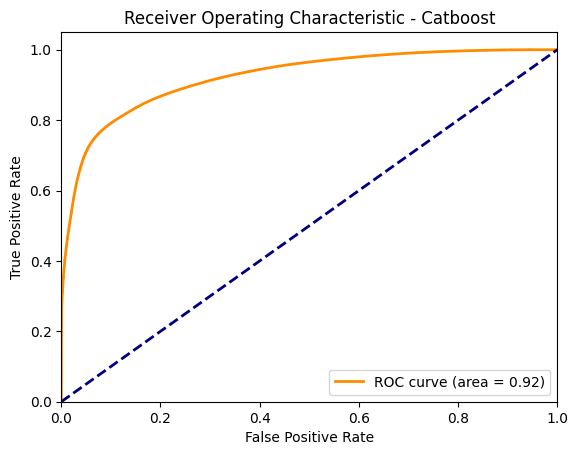

Accuracy: 0.89


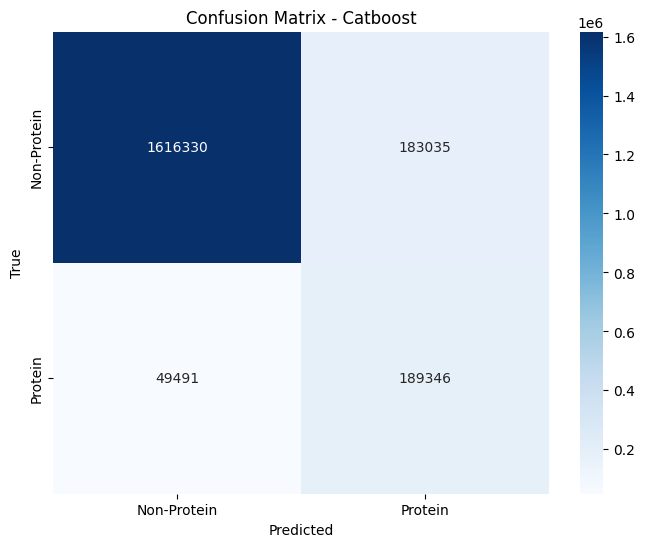

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93   1799365
           1       0.51      0.79      0.62    238837

    accuracy                           0.89   2038202
   macro avg       0.74      0.85      0.78   2038202
weighted avg       0.92      0.89      0.90   2038202



In [13]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix, classification_report
)

# Define file path
model_path = "/content/drive/MyDrive/DS5500/CatBoost.pkl"

# Load the saved Catboost model
try:
    model = joblib.load(model_path)
    print(f"Loaded Catboost model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred = model.predict(X_val)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Catboost')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Catboost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


Loaded Decision Tree model from /content/drive/MyDrive/DS5500/Decision_Tree.pkl


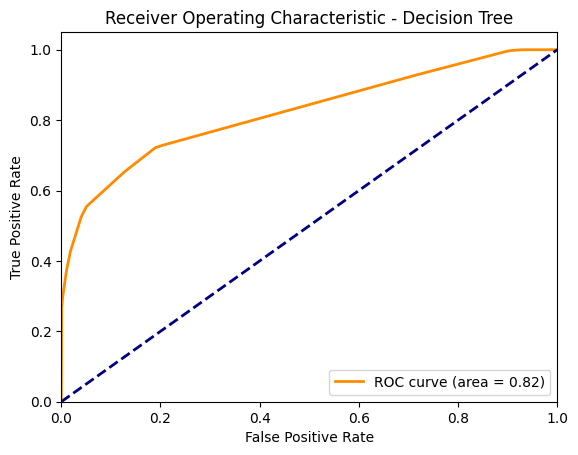

Accuracy: 0.80


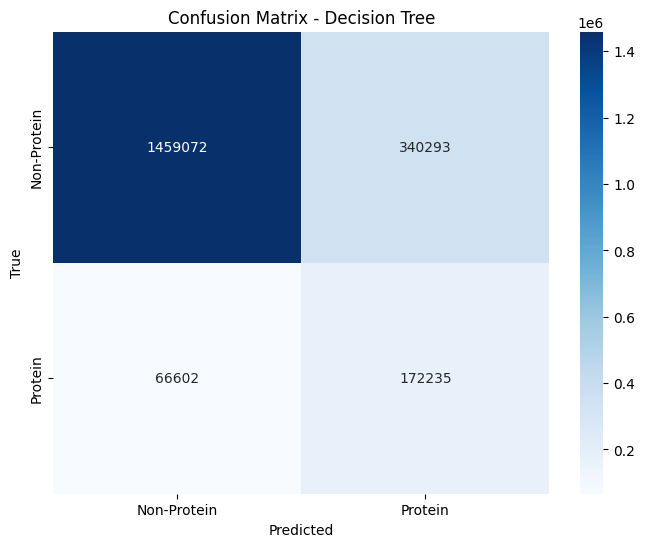

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88   1799365
           1       0.34      0.72      0.46    238837

    accuracy                           0.80   2038202
   macro avg       0.65      0.77      0.67   2038202
weighted avg       0.88      0.80      0.83   2038202



In [43]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix, classification_report
)

# Define file path
model_path = "/content/drive/MyDrive/DS5500/Decision_Tree.pkl"

# Load the saved CatBoost model
try:
    model = joblib.load(model_path)
    print(f"Loaded Decision Tree model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred = model.predict(X_val)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


Loaded Random Forest model from /content/drive/MyDrive/DS5500/saved_models/Random_Forest.pkl


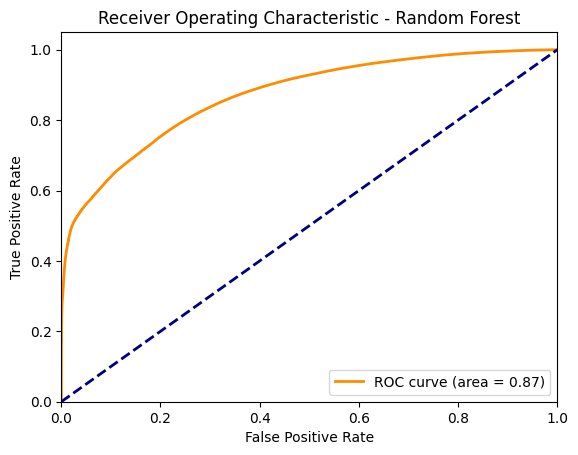

Accuracy: 0.86


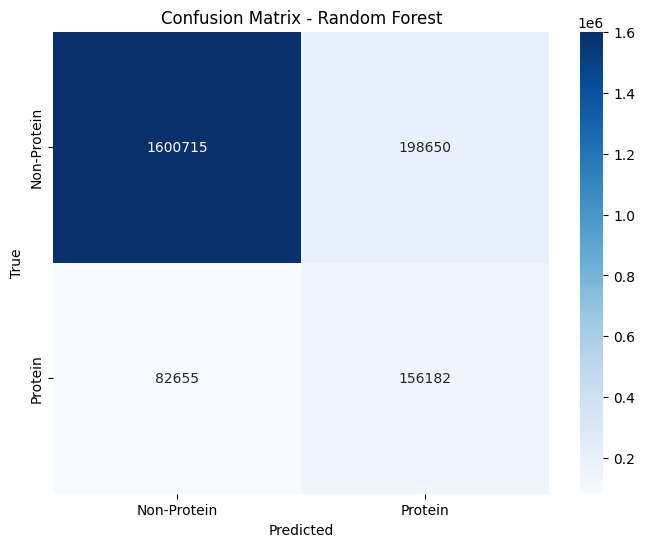

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92   1799365
           1       0.44      0.65      0.53    238837

    accuracy                           0.86   2038202
   macro avg       0.70      0.77      0.72   2038202
weighted avg       0.89      0.86      0.87   2038202



In [18]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix, classification_report
)

# Define file path
model_path = "/content/drive/MyDrive/DS5500/saved_models/Random_Forest.pkl"

# Load the saved CatBoost model
try:
    model = joblib.load(model_path)
    print(f"Loaded Random Forest model from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    raise

# Predictions
y_pred = model.predict(X_val)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


Weighted mAP for the Ensemble: 0.87


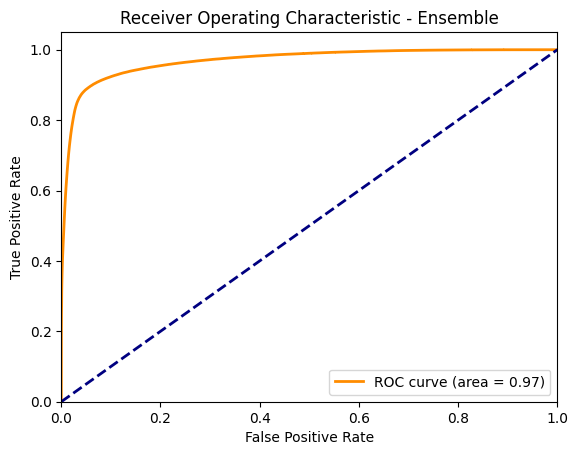

Accuracy: 0.95


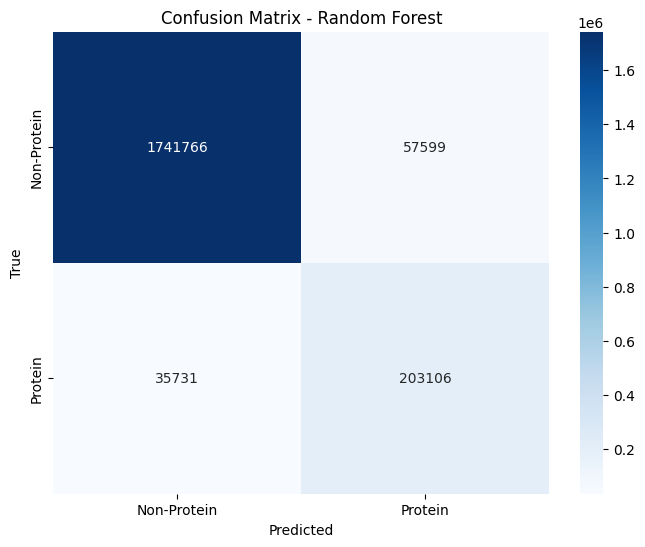

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1799365
           1       0.78      0.85      0.81    238837

    accuracy                           0.95   2038202
   macro avg       0.88      0.91      0.89   2038202
weighted avg       0.96      0.95      0.96   2038202



In [56]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

# Weights based on Weighted mAP
weights = weights = {
    "XGBoost": 0.45,
    "LGBM": 0.35,
    "CatBoost": 0.2
}


# Load trained models
models = {
    "XGBoost": joblib.load("/content/drive/MyDrive/DS5500/saved_models/XGBoost.pkl"),
    "LGBM": joblib.load("/content/drive/MyDrive/DS5500/LGBM.pkl"),
    "CatBoost": joblib.load("//content/drive/MyDrive/DS5500/CatBoost.pkl")
}

# Aggregate weighted probabilities
def weighted_ensemble_predict_proba(models, weights, X_val):
    # Determine the number of classes from one of the models
    n_classes = models["XGBoost"].n_classes_
    # Initialize weighted probabilities
    weighted_probas = np.zeros((X_val.shape[0], n_classes))
    for name, model in models.items():
        proba = model.predict_proba(X_val)
        weighted_probas += weights[name] * proba
    return weighted_probas

# Final predictions
def weighted_ensemble_predict(models, weights, X_val):
    weighted_probas = weighted_ensemble_predict_proba(models, weights, X_val)
    return np.argmax(weighted_probas, axis=1)

# Compute Weighted Mean Average Precision (mAP)
def compute_weighted_map(models, weights, X_val, y_val):
    # Get the weighted probabilities
    weighted_probas = weighted_ensemble_predict_proba(models, weights, X_val)
    # Use only the probability for the positive class
    proba_positive_class = weighted_probas[:, 1]
    # Compute Weighted mAP
    weighted_map = average_precision_score(y_val, proba_positive_class, average='weighted')
    return weighted_map

# Get weighted predictions
y_pred = weighted_ensemble_predict(models, weights, X_val)


# Compute Weighted mAP
weighted_map = compute_weighted_map(models, weights, X_val, y_val)
print(f"Weighted mAP for the Ensemble: {weighted_map:.2f}")

# ROC Curve
proba = weighted_ensemble_predict_proba(models, weights, X_val)
fpr, tpr, _ = roc_curve(y_val, proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - Ensemble")
plt.legend(loc="lower right")
plt.show()


# Evaluate the accuracy of ensemble model
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))


In [62]:
X_train

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]], dtype=float32)

In [63]:
import numpy as np

# Generate meta-features (predictions from base models)
X_meta_train = np.column_stack([
    models["XGBoost"].predict_proba(X_train)[:, 1],  # Probability for class 1
    models["LGBM"].predict_proba(X_train)[:, 1],
    models["CatBoost"].predict_proba(X_train)[:, 1]
])

# Generate meta-features for validation data
X_meta_val = np.column_stack([
    models["XGBoost"].predict_proba(X_val)[:, 1],
    models["LGBM"].predict_proba(X_val)[:, 1],
    models["CatBoost"].predict_proba(X_val)[:, 1]
])

# The target remains the same
y_meta_train = y_train
y_meta_val = y_val


In [64]:
# Define the meta-model with multi-threading
meta_model = LogisticRegression(solver='saga', max_iter=200, n_jobs=-1)

# Train the meta-model
meta_model.fit(X_meta_train, y_meta_train)

# Save the meta-model
joblib.dump(meta_model, '/content/drive/MyDrive/DS5500/saved_models/meta_model.pkl')
print("Meta-model saved successfully.")

Meta-model saved successfully.


In [71]:
 # Predictions
pred_model = meta_model.predict(X_meta_val)
pred_proba = meta_model.predict_proba(X_meta_val)[:, 1] if hasattr(model, "predict_proba") else None

# Metrics
accuracy = accuracy_score(y_meta_val, pred_model)
weighted_map = (
average_precision_score(y_meta_val, pred_proba, average='weighted') if pred_proba is not None else None
)

# Classification report
report = classification_report(y_meta_val, pred_model)

# Display results
print(f"Model: Ensemble model using stacking")
print(f"Accuracy: {accuracy:.2f}")
if weighted_map is not None:
  print(f"Weighted mAP: {weighted_map:.2f}")
  print(report)

Model: Ensemble model using stacking
Accuracy: 0.96
Weighted mAP: 0.87
              precision    recall  f1-score   support

           0       0.96      0.99      0.97   1799365
           1       0.88      0.72      0.79    238837

    accuracy                           0.96   2038202
   macro avg       0.92      0.85      0.88   2038202
weighted avg       0.95      0.96      0.95   2038202



Stacking model loaded successfully.
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97   1799365
           1       0.88      0.72      0.79    238837

    accuracy                           0.96   2038202
   macro avg       0.92      0.85      0.88   2038202
weighted avg       0.95      0.96      0.95   2038202

Weighted mAP: 0.87


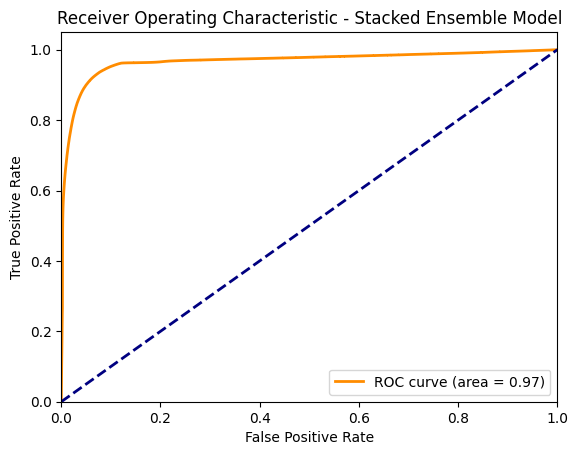

Stacking Model Accuracy: 0.96


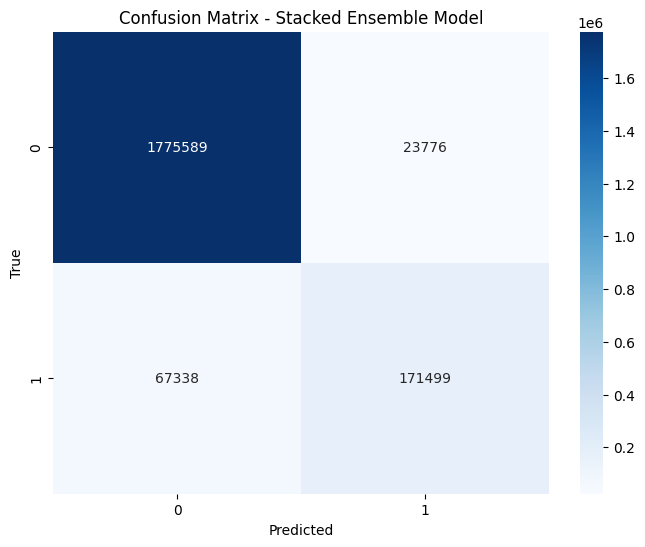

In [73]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib

# Load the saved stacking model
model_stacked = joblib.load('/content/drive/MyDrive/DS5500/saved_models/meta_model.pkl')
print("Stacking model loaded successfully.")

# Use the loaded model for predictions
y_pred = model_stacked.predict(X_meta_val)

# Classification Report
print("Classification Report:")
print(classification_report(y_meta_val, y_pred))
print(f"Weighted mAP: {weighted_map:.2f}")
# Check if the model supports predict_proba for ROC Curve
if hasattr(model_stacked, "predict_proba"):
    # Generate probabilities for the positive class
    proba_positive = model_stacked.predict_proba(X_meta_val)[:, 1]

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_meta_val, proba_positive)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Stacked Ensemble Model')
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.show()

else:
    print("The model does not support `predict_proba`. ROC curve cannot be generated.")

# Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Stacking Model Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_meta_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Stacked Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('True')
# Update xticks and yticks dynamically based on unique classes in y_val
class_labels = sorted(set(y_meta_val))
plt.xticks(ticks=[i + 0.5 for i in range(len(class_labels))], labels=class_labels)
plt.yticks(ticks=[i + 0.5 for i in range(len(class_labels))], labels=class_labels)
plt.show()


## **Hyperparameter Tuning**